Epoch 1/40
30/30 [==============================] - 1s 12ms/step - loss: 7038488576.0000 - val_loss: 1059911488.0000
Epoch 2/40
30/30 [==============================] - 0s 5ms/step - loss: 324466848.0000 - val_loss: 508899936.0000
Epoch 3/40
30/30 [==============================] - 0s 5ms/step - loss: 432920480.0000 - val_loss: 749534.5625
Epoch 4/40
30/30 [==============================] - 0s 5ms/step - loss: 63181068.0000 - val_loss: 405302976.0000
Epoch 5/40
30/30 [==============================] - 0s 5ms/step - loss: 1983477632.0000 - val_loss: 595992960.0000
Epoch 6/40
30/30 [==============================] - 0s 6ms/step - loss: 3431441152.0000 - val_loss: 248401840.0000
Epoch 7/40
30/30 [==============================] - 0s 5ms/step - loss: 1395785088.0000 - val_loss: 603814848.0000
Epoch 8/40
30/30 [==============================] - 0s 5ms/step - loss: 5978164224.0000 - val_loss: 602327616.0000
Epoch 9/40
30/30 [==============================] - 0s 5ms/step - loss: 259750688.000

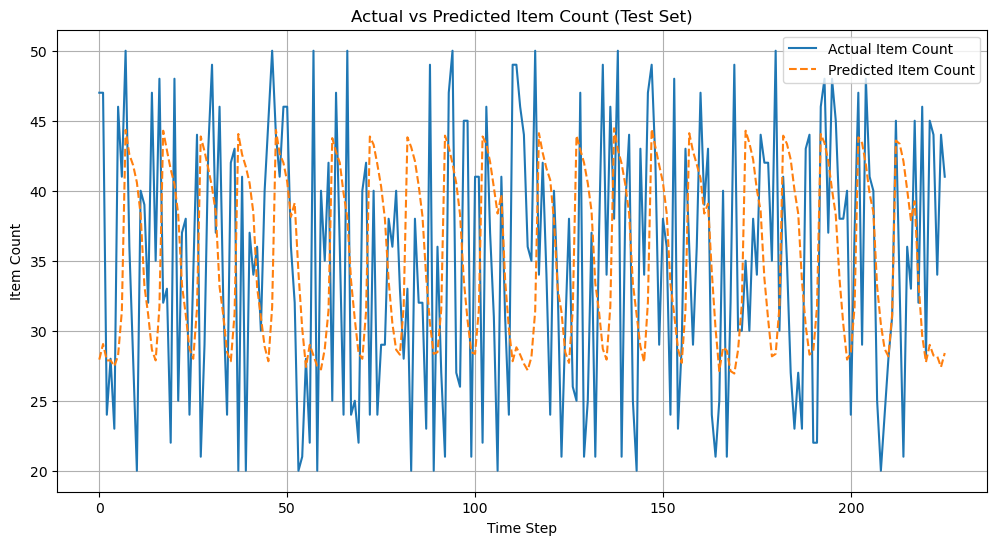

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. Load Data
df = pd.read_csv("Counts.csv")

# 2. Preprocessing
label_encoder = LabelEncoder()

df['Date'] = pd.to_datetime(df['Date'])  # Date only
df['Employee_ID'] = label_encoder.fit_transform(df['Employee_ID'])

scaler = MinMaxScaler(feature_range=(0, 1))
df[['Item_Count', 'Employee_ID']] = scaler.fit_transform(df[['Item_Count', 'Employee_ID']])

# 3. Feature Engineering
df['Date_Ordinal'] = df['Date'].map(pd.Timestamp.toordinal)

# Final Features:
X = df[['Date_Ordinal', 'Hour', 'Employee_ID']].values
y = df['Item_Count'].values

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# 5. Create Sequences
def create_sequences(X, y, n_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X[i:i+n_steps])
        y_seq.append(y[i+n_steps])
    return np.array(X_seq), np.array(y_seq)

n_steps = 10

X_train_seq, y_train_seq = create_sequences(X_train, y_train, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, n_steps)

# 6. Build the LSTM Model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_steps, X_train_seq.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 7. Train the Model
model.fit(X_train_seq, y_train_seq, epochs=40, batch_size=32, validation_data=(X_test_seq, y_test_seq))

model.save("CountsModel.keras")

# 8. Predictions
y_pred_scaled = model.predict(X_test_seq)

# 9. Inverse Transform Predictions (only for item count)
dummy_pred = np.zeros((len(y_pred_scaled), 2))
dummy_pred[:, 0] = y_pred_scaled.flatten()

dummy_test = np.zeros((len(y_test_seq), 2))
dummy_test[:, 0] = y_test_seq.flatten()

y_pred = scaler.inverse_transform(dummy_pred)[:, 0]
y_true = scaler.inverse_transform(dummy_test)[:, 0]

# 10. Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual Item Count')
plt.plot(y_pred, label='Predicted Item Count', linestyle='--')
plt.title('Actual vs Predicted Item Count (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('Item Count')
plt.legend()
plt.grid(True)
plt.show()
